# IS319 - Deep Learning

## TP2 - Dogs vs. cats (TensorFlow/Keras)

Credits: Baptiste Pesquet

![Woof Meow](woof_meow.jpg)

In this TP, the goal is to train neural networks to classify images of dogs and cats, using the TensorFlow/Keras library.

The images used in this TP are extracted from the [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/) dataset available on Kaggle, which contains 25000 images. First, we use a subset of 2000 images to decrease training time, for educational purposes. Later on, you can experiment with the full dataset using a GPU.

Most questions are open-ended: feel free to experiment with different settings. **Remember to analyze and explain what you are doing in additional cells.**

## Environment setup

In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Import TensorFlow modules (edit this list if needed)
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16

TensorFlow version: 2.14.0


## Utility function

In [ ]:
def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy"""
    loss = history.history['loss']
    acc = history.history['accuracy']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if 'val_accuracy' in history.history:
        val_acc = history.history['val_accuracy']
        plt.plot(epochs, val_acc, 'o-', label='Validation acc')
        final_val_acc = val_acc[-1]
        title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
    plt.title(title)
    plt.legend()

    plt.tight_layout()

## 1. Load and explore the dataset

In [ ]:
# Downloading our example data, a .zip of 2000 JPG pictures, and extracting it locally in `/tmp`
!wget --no-check-certificate --no-clobber \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

# Extracting zip file to the base directory `/tmp/cats_and_dogs_filtered`
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

# Directories with training/validation cat/dogs pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

# Display the sizes of our dataset
print(f'Number of train cat images: {len(os.listdir(train_cats_dir))}')
print(f'Number of train dog images: {len(os.listdir(train_dogs_dir))}')
print(f'Number of valid cat images: {len(os.listdir(valid_cats_dir))}')
print(f'Number of valid dog images: {len(os.listdir(valid_dogs_dir))}')

# Display some images files for cats and dogs
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])
train_dog_fnames = os.listdir(train_dogs_dir)
print(train_dog_fnames[:10])

--2023-11-06 09:52:35--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.251, 172.217.164.27, 172.217.0.91, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   112MB/s    in 0.6s    

2023-11-06 09:52:36 (112 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Number of train cat images: 1000
Number of train dog images: 1000
Number of valid cat images: 500
Number of valid dog images: 500
['cat.664.jpg', 'cat.17.jpg', 'cat.174.jpg', 'cat.807.jpg', 'cat.379.jpg', 'cat.315.jpg', 'cat.860.jpg', 'cat.558.jpg', 'cat.933.jpg', 'cat.631.jpg']
['dog.42.jpg', 'dog.162.jpg', 'dog.123.jpg', 'dog.575.jpg', 'dog.715.jpg', 'dog.701.jpg', 'dog.181.jpg', '

**(Question)** Display some images of cats and dogs from the train set and the validation set.

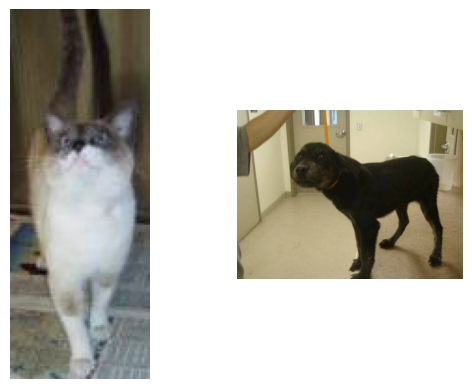

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display the PNG image
img_cat = mpimg.imread(f"{train_cats_dir}/{train_cat_fnames[0]}")
img_dog = mpimg.imread(f"{train_dogs_dir}/{train_dog_fnames[0]}")

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(img_cat)
ax2.imshow(img_dog)
ax1.axis("off")
ax2.axis("off")
plt.show()



## 2. Prepare the dataset

**(Question)** Following the documentation, use the `tf.keras.utils.image_dataset_from_directory` function to create `train_dataset` and `valid_dataset` objects from the directory paths defined above. Make sure to have binary labels as we are doing binary classification. To start, you can use a lower image size (for example 128x128).

In [ ]:
# YOUR CODE HERE
df_train = tf.keras.utils.image_dataset_from_directory(train_dir, labels='inferred',batch_size=32)
df_valid = tf.keras.utils.image_dataset_from_directory(valid_dir, labels='inferred', batch_size=32)



Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Convert data to numpy arrays

In [ ]:
X_train = tf.concat([images for images, _ in df_train], axis=0).numpy()
y_train = tf.concat([labels for _, labels in df_train], axis=0).numpy()
permutation = np.random.permutation(len(X_train))
X_train = X_train[permutation]
y_train = y_train[permutation]


X_test = tf.concat([images for images, _ in df_valid], axis=0).numpy()
y_test = tf.concat([labels for _, labels in df_valid], axis=0).numpy()
permutation = np.random.permutation(len(X_test))
X_test = X_test[permutation]
y_test = y_test[permutation]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
print("Training : ", X_train.shape, y_train.shape)
print("Testing : ", X_test.shape, y_test.shape)
print("Validation : ", X_valid.shape, y_valid.shape)

Training :  (1600, 256, 256, 3) (1600,)
Testing :  (1000, 256, 256, 3) (1000,)
Validation :  (400, 256, 256, 3) (400,)


In [ ]:
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

print(np.mean(X_train), np.mean(X_test))

0.44776702 0.45159993


In [ ]:
id = np.eye(2)
y_train_hot = id[y_train]
y_valid_hot = id[y_valid]
y_test_hot = id[y_test]

print(y_train_hot.shape, y_valid_hot.shape, y_test_hot.shape)

(1600, 2) (400, 2) (1000, 2)


## 3. Training CNN models

**(Question)** Create a CNN classification model able to be trained on your dataset. Show its summary with the `model.summary()`method.
Make sure to include a layer to normalize input data (or to normalize your dataset object beforehand).

In [ ]:
# YOUR CODE HERE

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(256,256,3)))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D()) #128
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D()) #64
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D()) #32
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D()) #16


model.add(Flatten())

model.add(Dense(16*32,activation='relu'))
model.add(Dense(8*32,activation='relu'))
model.add(Dense(2*32,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(2,activation='softmax'))


model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train_hot, batch_size=64, epochs=10, validation_data=(X_valid, y_valid_hot))



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        1

**(Question)** "Compile" and train your model with an appropriate loss function. Monitor train and validation accuracy (you can use the `plot_loss_acc` function defined above). You should be able to reach a validation accuracy >70%. Analyze your results.

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test_hot)

print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

32/32 [==============================] - 57s 2s/step - loss: 0.6931 - accuracy: 0.5000
Test loss: 0.6931494474411011
Test accuracy: 0.5


In [ ]:
tf.config.list_physical_devices('GPU')


[]

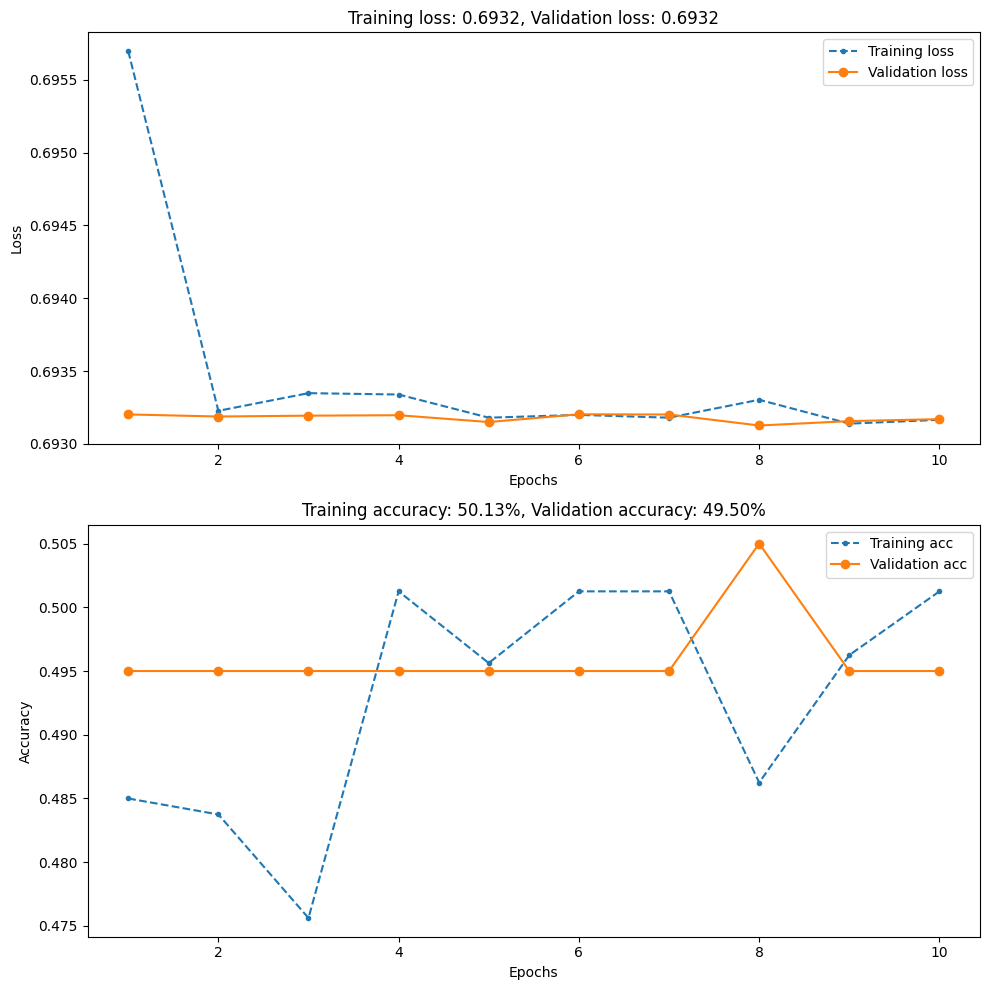

In [ ]:
# YOUR CODE HERE
plot_loss_acc(history)

**(Question)** Make sure your code is using a GPU if one is available. Modify your code accordingly, if necessary. What kind of speedup do you observe?

## 4. Preventing overfitting

**(Question)** Experiment with various deep learning techniques to prevent overfitting.

Some suggested strategies are:

- Adding data augmentation: possible transformations are random (horizontal) flips, rotations, translations, crops, and zooms
    - (When using data augmentation, it is always good to visualize some of your transformations)
- Adding dropout to the classification part
- Adding appropriate batch normalization layers in different parts of the network

In [ ]:
# YOUR CODE HERE
from scipy.ndimage import rotate, zoom


def hor_flip(img):
  return np.flip(img, axis=1)

def ver_flip(img):
  return np.flip(img, axis=0)

def rotate_img(img, angle=90):
  return rotate(img, angle=angle, reshape=False, mode='nearest')

def zoom_img(img, zoom_rate=2):
  n = img.shape[0]
  roi_start = int(n * (zoom_rate - 1) / (2 * zoom_rate))
  roi_end = int(n * (zoom_rate + 1) / (2 * zoom_rate))
  return zoom(img[roi_start:roi_end, roi_start:roi_end], zoom=zoom_rate, mode='nearest')


# if axis = 0 then new_image[0:, tr:]

def translate_img(img, tr_rate=32, axis=0):
  new_img = np.zeros_like(img)
  n = img.shape[0]
  new_img[axis*tr_rate:, (1-axis)*tr_rate :] = img[: n - axis*tr_rate, : n - (1-axis)*tr_rate]
  return new_img

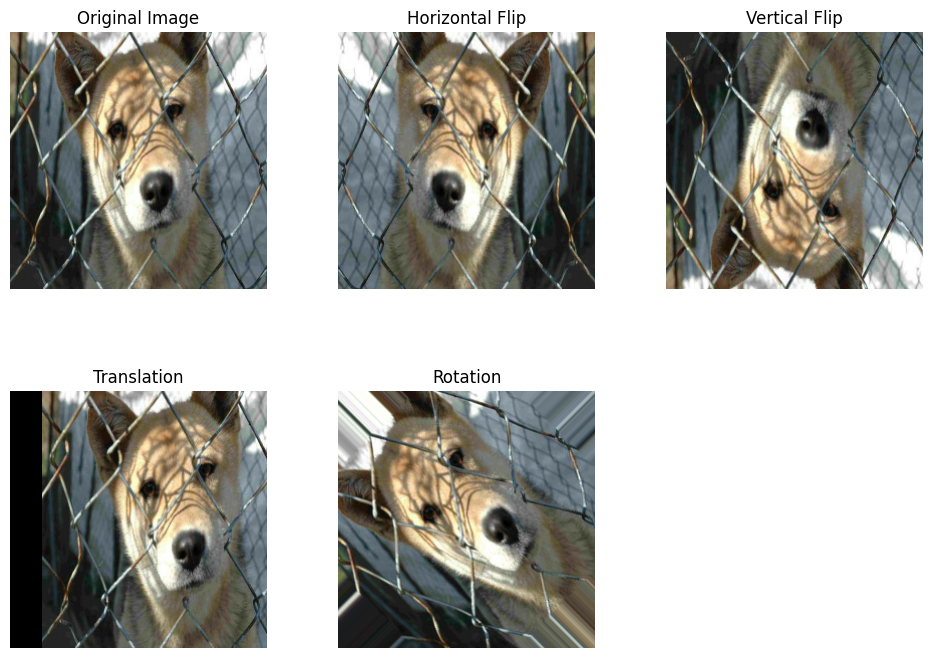

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

image_array = X_train[0]

# Original Image
axs[0, 0].imshow(image_array)
axs[0, 0].set_title("Original Image")

# Horizontal Flip
horizontal_flip_image = hor_flip(image_array)
axs[0, 1].imshow(horizontal_flip_image)
axs[0, 1].set_title("Horizontal Flip")

# Vertical Flip
vertical_flip_image = ver_flip(image_array)
axs[0, 2].imshow(vertical_flip_image)
axs[0, 2].set_title("Vertical Flip")

# Translation
translated_image = translate_img(image_array)
axs[1, 0].imshow(translated_image)
axs[1, 0].set_title("Translation")

# Rotation
rotated_image = rotate_img(image_array, angle=45)
axs[1, 1].imshow(rotated_image)
axs[1, 1].set_title("Rotation")


# Hide axis labels and ticks
for ax in axs.flat:
    ax.axis('off')

# Adjust spacing
plt.subplots_adjust(wspace=0.2, hspace=0.4)

plt.show()

In [ ]:
def data_aug(X,y):
  X_aug = np.copy(X)
  y_aug = np.copy(y)
  for img,label in zip(X, y):
    np.append(X_aug, translate_img(img, np.random.randint(10,128)))
    np.append(y_aug, label)
    np.append(X_aug, rotate_img(img, np.random.randint(0,360)))
    np.append(y_aug, label)
    np.append(X_aug, ver_flip(img))
    np.append(y_aug, label)
    np.append(X_aug, hor_flip(img))
    np.append(y_aug, label)

  permutation = np.random.permutation(len(X_aug))
  X_aug = X_aug[permutation]
  y_aug = y_aug[permutation]
  return X_aug, y_aug

X_train_aug, y_train_aug = data_aug(X_train, y_train)
X_test_aug, y_test_aug = data_aug(X_test, y_test)

X_train_aug, X_valid_aug, y_train_aug, y_valid_aug = train_test_split(X_train_aug, y_train_aug, test_size=0.2)

print("Training", X_train_aug.shape, y_train_aug.shape)
print("Validation", X_valid_aug.shape, y_valid_aug.shape)
print("Testing", X_test_aug.shape, y_test_aug.shape)


Training (1280, 256, 256, 3) (1280,)
Validation (320, 256, 256, 3) (320,)
Testing (1000, 256, 256, 3) (1000,)


**(Question)** Train your model with deep learning techniques. Analyze the results and compare with the previous model.

In [ ]:
def custom_model(batch_normalization=True, dropout=True):

  model = Sequential()

  model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(256,256,3)))
  if dropout:
    model.add(Dropout(0.2))
  model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(256,256,3)))
  model.add(MaxPooling2D()) #128
  if batch_normalization:
    model.add(BatchNormalization())
  model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling2D()) #64
  model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
  if dropout:
    model.add(Dropout(0.2))
  model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling2D()) #32
  if batch_normalization:
    model.add(BatchNormalization())
  model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling2D()) #16


  model.add(Flatten())

  model.add(Dense(16*32,activation='relu'))
  model.add(Dense(8*32,activation='relu'))
  if batch_normalization:
    model.add(BatchNormalization())
  model.add(Dense(2*32,activation='relu'))
  model.add(Dense(32,activation='relu'))
  model.add(Dense(2,activation='softmax'))

  return model

In [ ]:
base_model = custom_model(False, False)

base_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

base_model.summary()

base_history = base_model.fit(X_train_aug, y_train_aug, batch_size=64, epochs=10, validation_data=(X_valid_aug, y_valid_hot))



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)       

ValueError: ignored

In [ ]:
dropout_model = custom_model(False, True)

dropout_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

dropout_model.summary()

dropout_history = dropout_model.fit(X_train_aug, y_train_aug, batch_size=64, epochs=10, validation_data=(X_valid_aug, y_valid_hot))



In [ ]:
batchnormalization_model = custom_model(True, False)


batchnormalization_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

batchnormalization_model.summary()

batchnormalization_history = batchnormalization_model.fit(X_train_aug, y_train_aug, batch_size=64, epochs=10, validation_data=(X_valid_aug, y_valid_hot))

In [ ]:
full_model = custom_model(True, True)

full_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

full_model.summary()

full_history = full_model.fit(X_train_aug, y_train_aug, batch_size=64, epochs=10, validation_data=(X_valid_aug, y_valid_hot))

In [ ]:
plt.figure(figsize=(10, 10))

plt.add_subplot(321)
plot_loss_acc(history)
plt.title('base model')

plt.add_subplot(322)
plot_loss_acc(base_history)
plt.title('base model with data augmentation')

plt.add_subplot(323)
plot_loss_acc(batchnormalization_history)
plt.title('batch normalization')

plt.add_subplot(324)
plot_loss_acc(dropout_history)
plt.title('dropout')

plt.add_subplot(325)
plot_loss_acc(full_history)
plt.title('batchnoralization + dropout')



---



## 5. Finetuning a pretrained model

**(Question)** Load the feature extraction part of VGG16 model. The feature extraction part corresponds to the CNN part, without the MLP classifier at the end.

In [ ]:
# YOUR CODE HERE
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights=None, include_top=False, input_shape=(256,256,3))

**(Question)** Add a custom MLP classifier on top of the VGG16 feature extraction part.

In [ ]:
# YOUR CODE HERE
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

**(Question)** Compile and train your model. You should be able to reach a validation accuracy >87%. Analyze your results and compare with your initial model trained from scratch.

In [ ]:
# YOUR CODE HERE
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train_hot, batch_size=64, epochs=10, validation_data=(X_valid, y_valid_hot))